### XGBoost Timeseries Forecast - Energy Prices

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('AEP_hourly.csv',  index_col=[0], parse_dates=[0])

<Axes: title={'center': 'AEP Energy Use'}, xlabel='Datetime'>

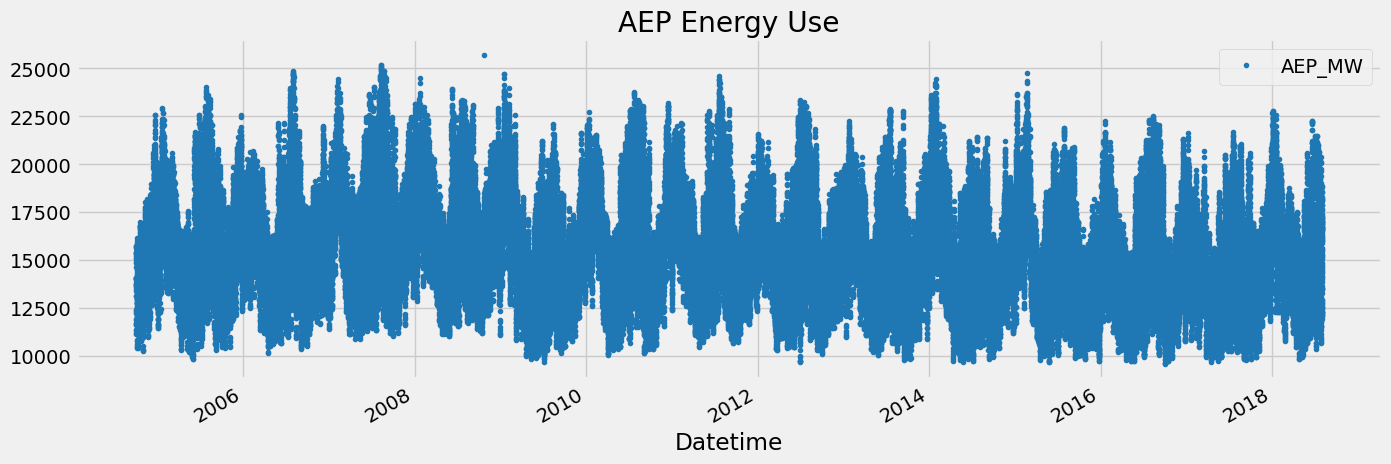

In [3]:
df.plot(style='.', figsize=(15,5), color=color_pal[0], title="AEP Energy Use")

#### Train / Test split

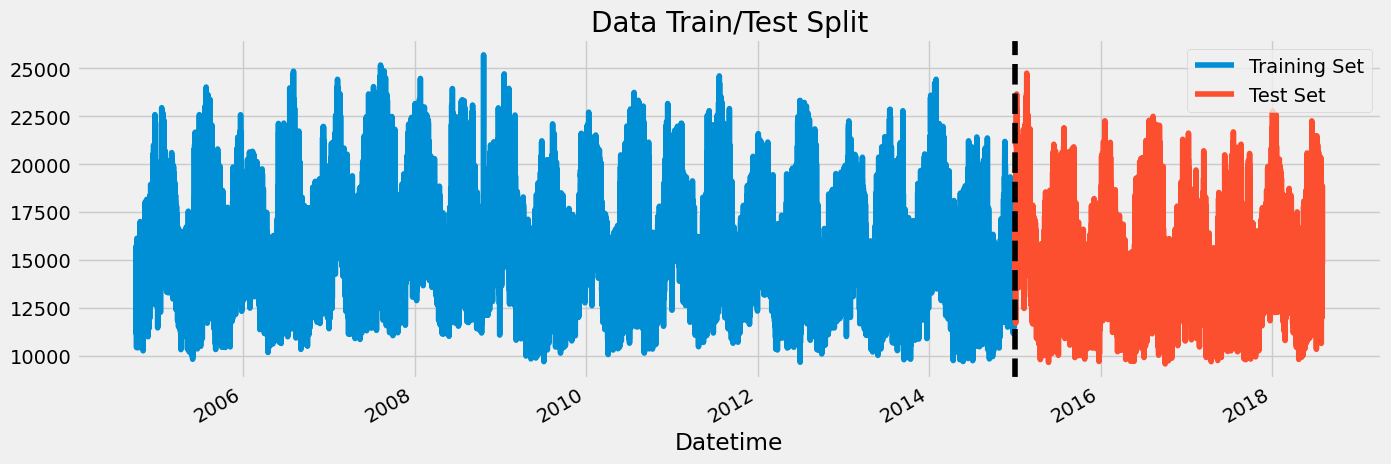

In [4]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set','Test Set'])
ax.set_title('Data Train/Test Split')
plt.show()

<Axes: title={'center': 'Week of Data'}, xlabel='Datetime'>

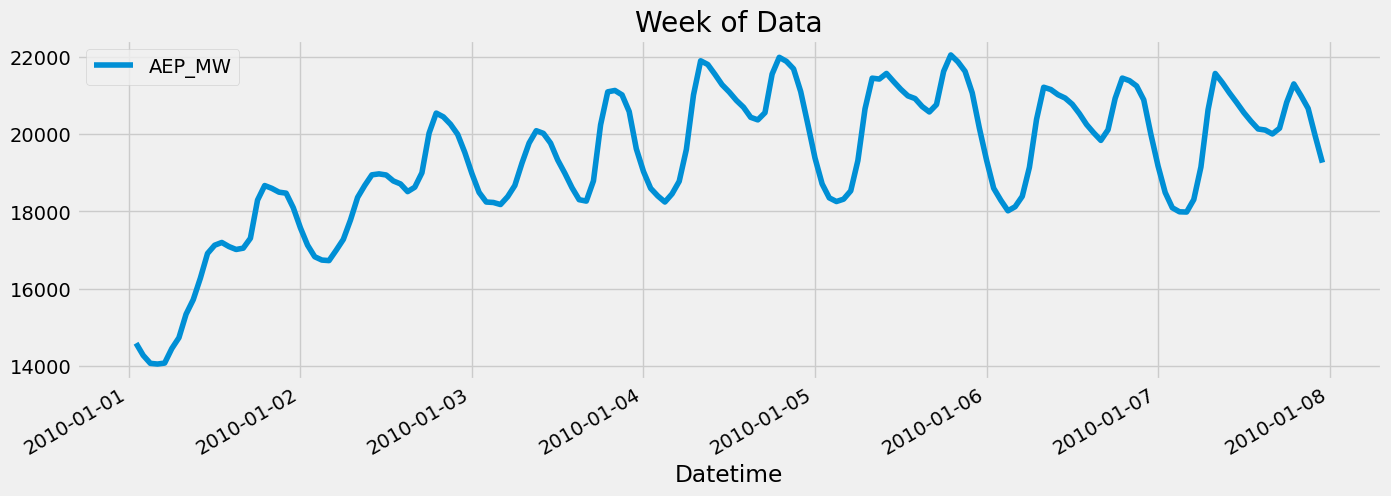

In [5]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize=(15,5), title='Week of Data')

#### Add More Date Features

In [6]:
#Feature creation
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.day_of_week
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.day_of_year
    return df
df_full = create_features(df)

#### Data Distribution - Boxplot

Text(0.5, 1.0, 'MW by month')

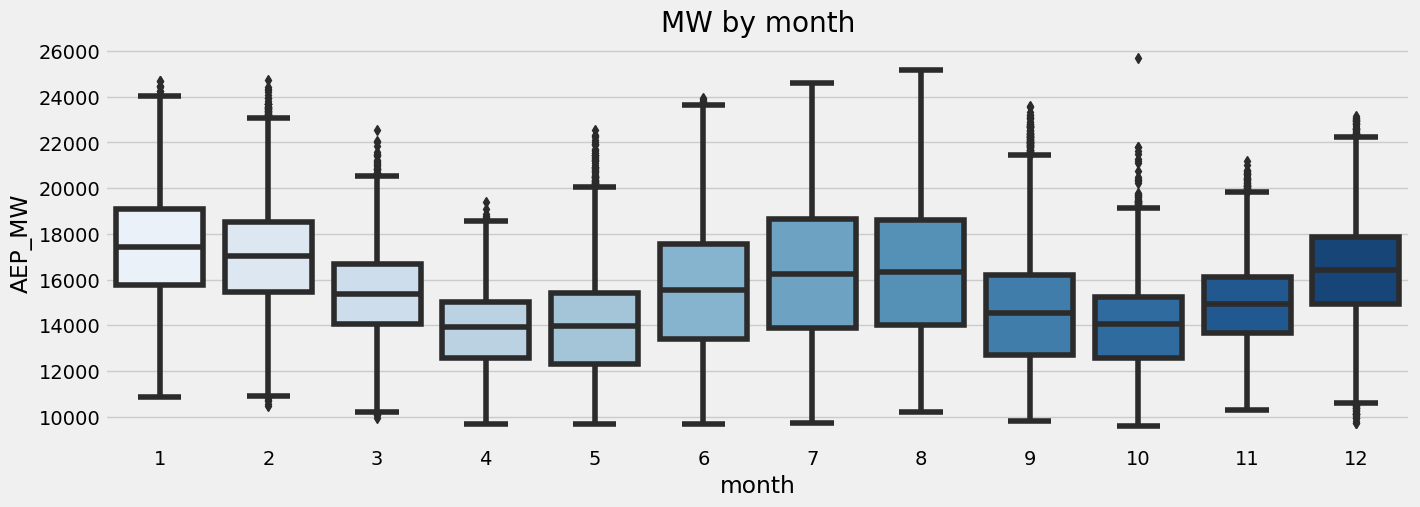

In [7]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df_full, x='month',y='AEP_MW', palette='Blues')
ax.set_title('MW by month')

#### XGBoost Model Set-up

In [8]:
train = create_features(train)
test = create_features(test)

In [9]:
col_features = df_full.select_dtypes(include=['number']).columns.drop(['AEP_MW'])

In [10]:
FEATURES = col_features
TARGET = 'AEP_MW'

In [11]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

#### XGBoost Model Fit

In [12]:
reg = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50,learning_rate=0.001)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_test, y_test)],verbose=100)

[0]	validation_0-rmse:2571.77747	validation_1-rmse:2683.12724
[100]	validation_0-rmse:2418.78537	validation_1-rmse:2543.72673
[200]	validation_0-rmse:2285.21737	validation_1-rmse:2424.24267
[300]	validation_0-rmse:2168.46028	validation_1-rmse:2320.84646
[400]	validation_0-rmse:2066.27063	validation_1-rmse:2231.99828
[500]	validation_0-rmse:1977.35291	validation_1-rmse:2156.44867
[600]	validation_0-rmse:1900.68213	validation_1-rmse:2095.13001
[700]	validation_0-rmse:1832.44385	validation_1-rmse:2040.87265
[800]	validation_0-rmse:1772.78374	validation_1-rmse:1993.65343
[900]	validation_0-rmse:1720.60363	validation_1-rmse:1949.47821
[999]	validation_0-rmse:1674.54889	validation_1-rmse:1911.14625


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### Analyse Feature Importance After Fititng

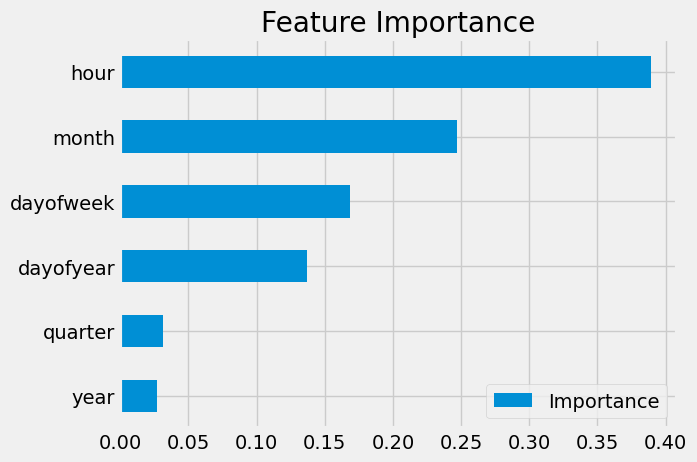

In [13]:
#feature importance
feature_importance = pd.DataFrame(data=reg.feature_importances_, index=FEATURES,columns=['Importance'])
feature_importance.sort_values('Importance').plot(kind='barh', title='Feature Importance')
plt.show()

#### Predication Model Back-testing Analyse

In [14]:
test['AEP_MW_Predict'] = reg.predict(X_test)

df_full = df_full.merge(test[['AEP_MW_Predict']], how='left', left_index=True, right_index=True)


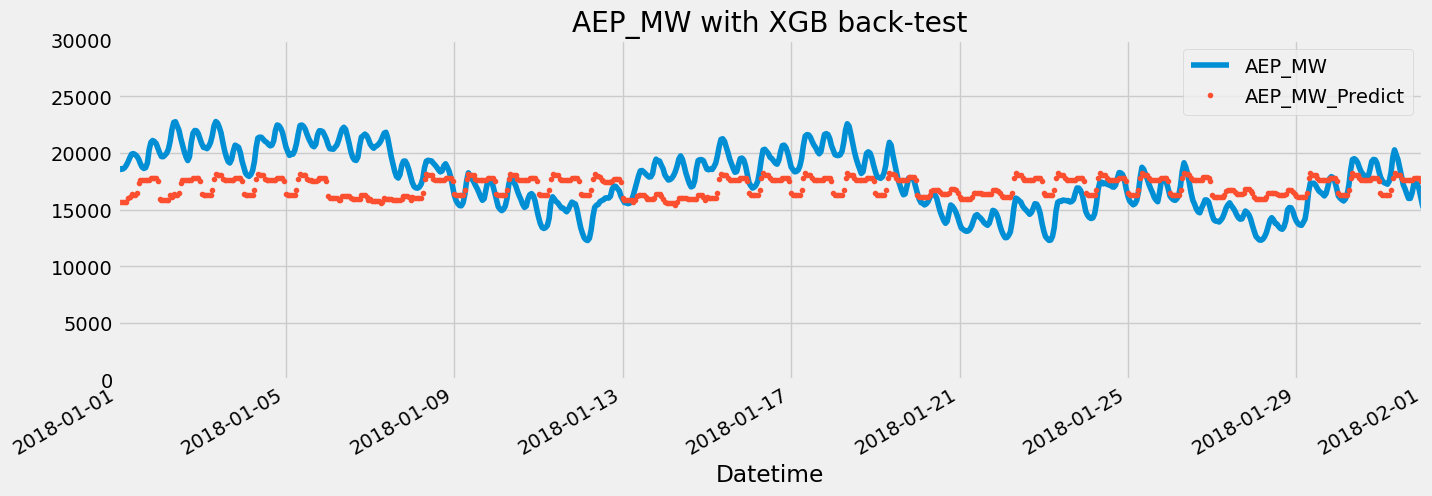

In [15]:
ax = df_full[['AEP_MW']].plot(figsize=(15,5))
df_full[['AEP_MW_Predict']].plot(ax=ax, style='.')
ax.set_xbound(lower='01-01-2018', upper='02-01-2018')
ax.set_ylim(0, 30000)
ax.set_title('AEP_MW with XGB back-test')
plt.show()

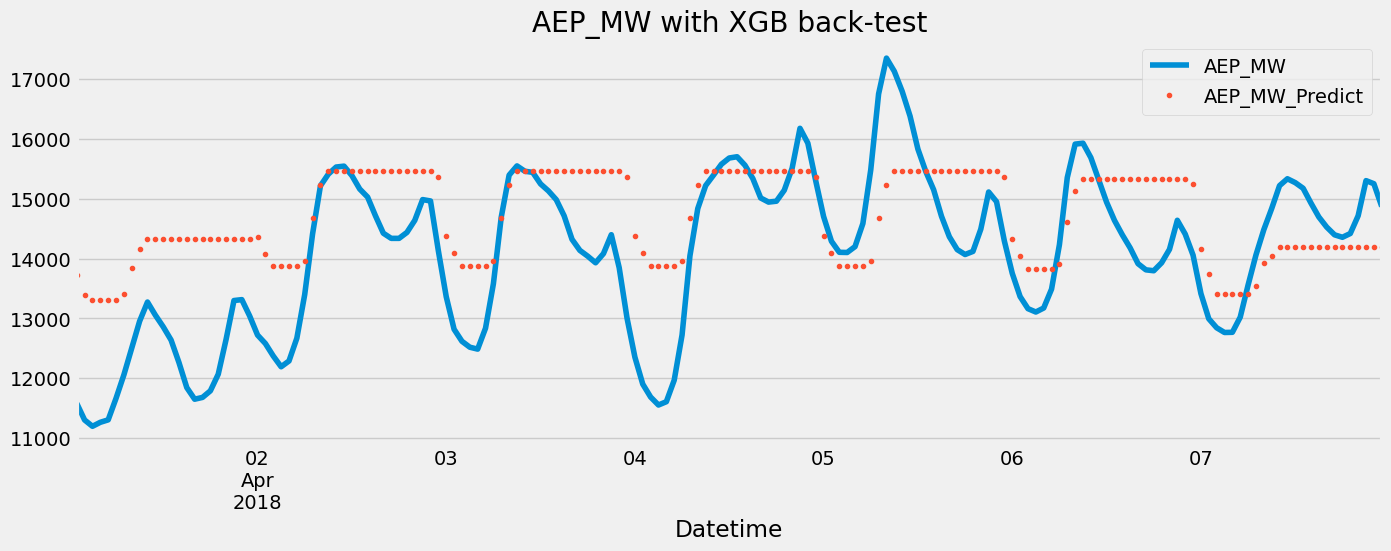

In [16]:
ax = df_full.loc[(df_full.index > '04-01-2018') & (df_full.index < '04-08-2018')][['AEP_MW']].plot(figsize=(15,5))
df_full.loc[(df_full.index > '04-01-2018') & (df_full.index < '04-08-2018')][['AEP_MW_Predict']].plot(ax=ax, style='.')
ax.set_title('AEP_MW with XGB back-test')
plt.show()

#### Calculate RMSE Model Eval Score

In [17]:
#model score
score = np.sqrt(mean_squared_error(test['AEP_MW'],test['AEP_MW_Predict'])) #true y, pred y_hat
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1911.15


#### Calculate Model Error Rate

In [18]:
#model error
test['Error'] = np.abs(test[TARGET] - test['AEP_MW_Predict'])

#### Discover Top 5 Best and Worst Predicated Observations

In [19]:
test['date'] = test.index.date

In [20]:
#Top 5 best predication days
test.groupby('date')['Error'].mean().sort_values(ascending=True).head(5)

date
2018-08-03    199.906250
2016-03-04    364.277913
2017-02-03    365.161906
2017-12-17    392.280965
2016-02-26    396.142456
Name: Error, dtype: float64

In [21]:
#Worst 5 best predication days
test.groupby('date')['Error'].mean().sort_values(ascending=False).head(5)

date
2015-02-19    5413.341512
2015-02-20    5269.139038
2015-12-25    4974.974772
2018-01-06    4786.471436
2015-12-24    4571.338135
Name: Error, dtype: float64